#Multi-pocket ranking and virtual screening with PocketVina (P2Rank and QuickVina 2-GPU 2.1)

###PocketVina operates in 2 stages:
1. Prediction of potential protein pocket centers using P2Rank, a fast and accurate machine-learning algorithm that identifies ligandable regions on the protein’s solvent-accessible surface (SAS).

2. Molecular docking at each predicted pocket center using QuickVina 2-GPU 2.1, an accelerated version of AutoDock Vina optimized for GPU-based virtual screening.

### Why use QuickVina 2-GPU 2.1., instead of Vina, Glide, GOLD, etc?
 * QuickVina 2-GPU 2.1 is an optimized version of
 the AutoDock Vina family for high-throughput virtual screening (HTVS),
 further improving the speed of Vina-GPU 2.0 with the RILC-BFGS (Reduced
 Iteration and Low Complexity BFGS) algorithm to a few tens of milliseconds per dock.

 * PocketVina achieves large-scale docking throughput within just a few days, even when
 executed on standard GPU hardware (e.g., NVIDIA Tesla P40 with 6 GB VRAM).
 This demonstrates both the scalability and accessibility of the approach, making it
 particularly well suited for high-throughput virtual screening applications. PocketV
ina performs exhaustive sampling across multiple detected pocket centers using Vina’s
 GPUacceleration and repeats the optimization for multiple pockets, resulting in more
 rational pose estimates.
 * In several benchmarks- PDBbind2020, Astex Diverse
 Set [49], PoseBusters benchmark set, and DockGen - PocketVina showed the
 highest physically-valid success rates for rigid ligand docking compared to both traditional and DL-based models.
 * Sarigun et al. curated the TargetDock-AI benchmarking dataset
 to evaluate how well docking programs’ own scoring functions can distinguish active
 from inactive drug–target pairs. In this benchmark, PocketVina clearly outperformed
 the DL-based method by achieving accurate discrimination with minimal false positives.
 * On top of this, PocketVina’s runtime efficiency provides a valuable contribution
 to the structure-based drug design (SBDD) community in real-world high-throughput
 virtual screening scenarios.

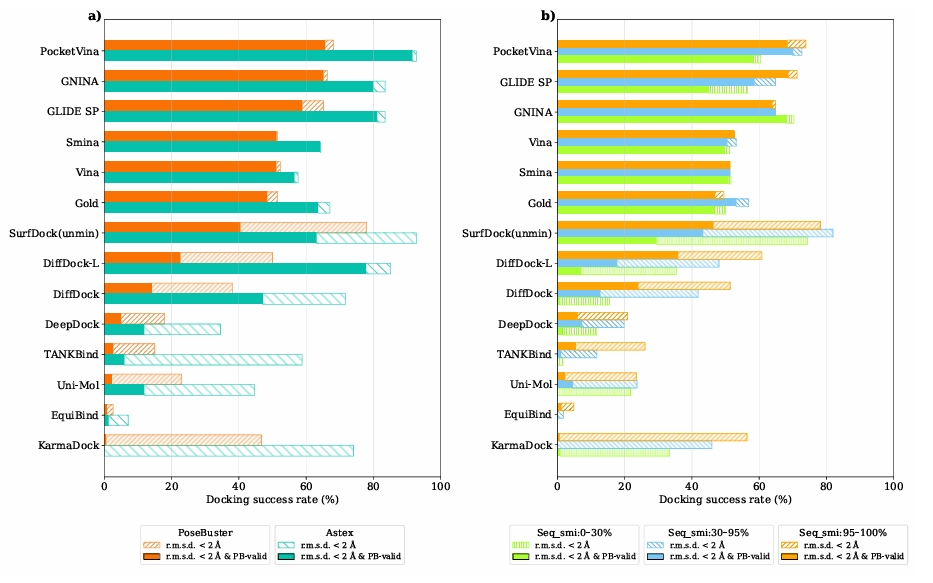



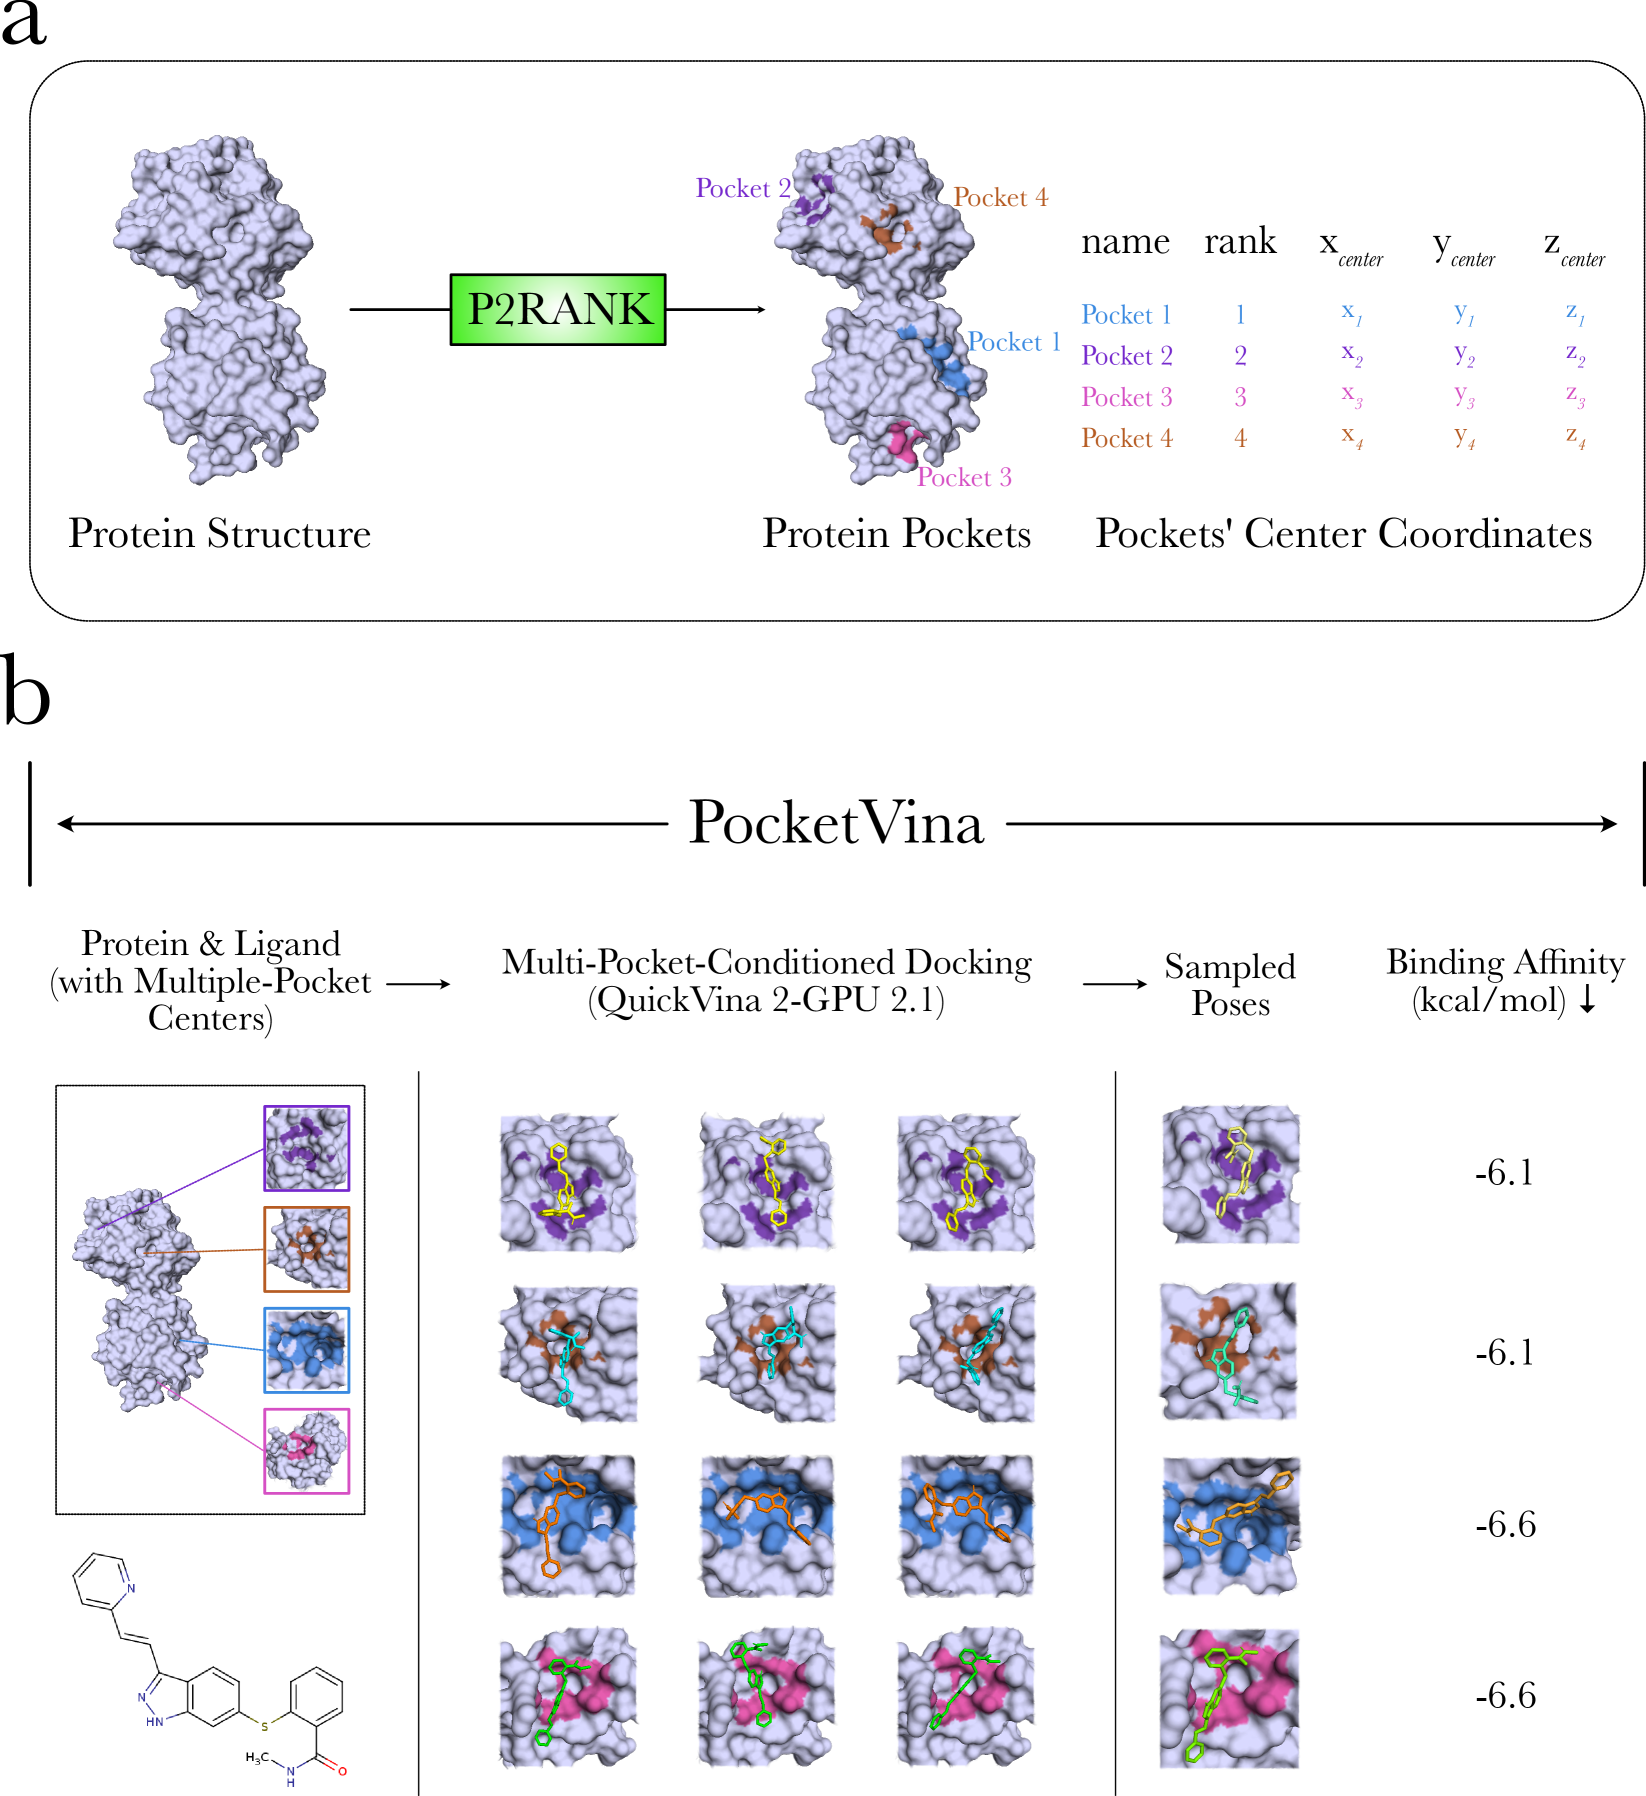

## ⚙️ **Before You Begin**

1. **Switch to GPU Runtime**  
   For best performance, go to the top menu and select:  
   `Runtime` → `Change runtime type` → Select **GPU**

2. **Run the Cells**  
   Use the ▶ button on the left of each code cell to execute it.

💬 **Note**:  
While this notebook is optimized for Google Colab, execution here may be **slower than on a properly configured local machine**, due to hardware and environment differences.  
Still, Colab is a great way to explore and test the code. For details on running PocketVina locally, see [Issue #2](https://github.com/BIMSBbioinfo/PocketVina/issues/2#issuecomment-3016724348).

🔗 **Resources**:  
- 🧬 [GitHub Repository](https://github.com/BIMSBbioinfo/PocketVina)  
- 📄 [arXiv Preprint](https://www.arxiv.org/abs/2506.20043)  
- 📊 [Raw Results & Datasets on Zenodo](https://zenodo.org/records/15733460)


In [1]:
#@title Initial Setup and Dependencies (~40 seconds)
%%capture
%cd /content
#@markdown - Clone PocketVina
!git clone https://github.com/BIMSBbioinfo/PocketVina
%cd PocketVina
!ls

#@markdown - Install Boost libraries
!apt-get update && apt-get install -y libboost-all-dev

#@markdown - Install Java 17
!apt-get remove -y openjdk*
!add-apt-repository -y ppa:linuxuprising/java
!apt-get update
!apt-get install -y openjdk-17-jdk
!java -version

In [2]:
#@title OpenCL Setup and GPU Configuration (~15 seconds)
%%capture
#@markdown - Install OpenCL dependencies
!apt-get update && apt-get install -y ocl-icd-opencl-dev opencl-headers nvidia-opencl-dev

#@markdown - Create OpenCL ICD registry for NVIDIA
!mkdir -p /etc/OpenCL/vendors
!echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd

#@markdown - Install and check clinfo
!apt install -y clinfo
!clinfo

#@markdown - Check GPU status
!nvidia-smi

In [3]:
#@title Set Environment Variables and Check Executables
%%capture
import os
cwd = os.getcwd()
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['OCL_ICD_VENDORS'] = '/etc/OpenCL/vendors'

# Make PocketVina-GPU executable
!chmod +x cwd/pocketvina/PocketVina-GPU

# Verify installations and permissions
!ls -l cwd/pocketvina/PocketVina-GPU
!ls -l cwd/pocketvina/QuickVina2-GPU-2-1

In [4]:
#@title 🔄 Update Relative Paths to Absolute Paths

file_path = "/content/PocketVina/example/protein_files.txt"
old_prefix = "Path/to"
new_prefix = "/content"

# Dosyayı oku, her satırda değişiklik yap
with open(file_path, "r") as f:
    lines = f.readlines()

# Güncellenmiş satırları yaz
with open(file_path, "w") as f:
    for line in lines:
        updated_line = line.replace(old_prefix, new_prefix)
        f.write(updated_line)

print("✅ Paths updated successfully!")

✅ Paths updated successfully!


In [5]:
#@title Build and Install PocketVina (~19 minutes)
%%capture
%pip install build
!python -m build
%pip install dist/pocketvina_gpu-0.1.0-py3-none-any.whl

* Upload you `protein.pdb` and `ligands.txt` file into the /example directory before running PocketVina.

In [6]:
#@title Fetch inputs from GitHub → local PocketVina paths

# Upload the protein list .txt file
!wget -O /content/PocketVina/example/protein_files.txt https://raw.githubusercontent.com/TomK-cpu/tensor-ai-site/refs/heads/main/protein_files.txt

# Upload the ligand list .txt file
!wget -O /content/PocketVina/example/ligands.txt https://raw.githubusercontent.com/TomK-cpu/tensor-ai-site/refs/heads/Ligands/exit5_products_chan_lam.smi

from pathlib import Path
from urllib.request import urlretrieve

Path("/content/PocketVina/example/proteins").mkdir(parents=True, exist_ok=True)
url = "https://raw.githubusercontent.com/TomK-cpu/tensor-ai-site/main/5RMM_pocket_restrained.pdb"
out = "/content/PocketVina/example/proteins/5RMM_pocket_restrained.pdb"
urlretrieve(url, out)

print("Saved:", out)
print(open(out).read().splitlines()[:5])



--2025-08-28 17:20:24--  https://raw.githubusercontent.com/TomK-cpu/tensor-ai-site/refs/heads/main/protein_files.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63 [text/plain]
Saving to: ‘/content/PocketVina/example/protein_files.txt’

/content/PocketVina 100%[===================>]      63  --.-KB/s    in 0s      

2025-08-28 17:20:24 (1.27 MB/s) - ‘/content/PocketVina/example/protein_files.txt’ saved [63/63]

--2025-08-28 17:20:24--  https://raw.githubusercontent.com/TomK-cpu/tensor-ai-site/refs/heads/Ligands/exit5_products_chan_lam.smi
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... conne

In [7]:
#@title Format ligands.txt in molecule_name, SMILES text format (required for PocketVina)
import os

file_path = "/content/PocketVina/example/ligands.txt"
output_file_path = "/content/PocketVina/example/ligands_modified.txt"

with open(file_path, "r") as f_in, open(output_file_path, "w") as f_out:
    f_out.write("molecule_name,smiles\n")
    for i, line in enumerate(f_in):
        smiles = line.strip()
        if smiles:
            f_out.write(f"molecule{i+1},{smiles}\n")

os.replace(output_file_path, file_path)

print("✅ Ligand file updated successfully!")

✅ Ligand file updated successfully!


In [8]:
#@title Run Pocket Vina
from pocketvina import PocketVinaGPU, PocketVinaConfig, P2RankConfig, PocketConfig

# For using direct protein paths with P2Rank
config = PocketVinaConfig(
    protein_paths=f"{cwd}/example/protein_files.txt", ## ABSOLUTE PATH
    smiles_file=f"{cwd}/example/ligands.txt", ## ABSOLUTE PATH
    output_dir=f"{cwd}/test", ## ABSOLUTE PATH
    batch_size=10,
    p2rank_config=P2RankConfig(
        threads=8,
        visualizations=False,
        vis_copy_proteins=False,
        output_dir=f"{cwd}/test", ## ABSOLUTE PATH
        model='alphafold' ## ABSOLUTE PATH
    ),
    pocket_config=PocketConfig(
            size_x=20,
            size_y=20,
            size_z=20,
            thread=1000
    )
)

pocketvina = PocketVinaGPU(config, htvs_mode = True)
pocketvina.execute_docking()

2025-08-28 17:22:46,237 - P2RankProcessor - INFO - Processing file list from: /content/PocketVina/example/protein_files.txt
INFO:P2RankProcessor:Processing file list from: /content/PocketVina/example/protein_files.txt
2025-08-28 17:22:46,240 - P2RankProcessor - INFO - Processing: /content/PocketVina/example/proteins/5RMM_pocket_restrained.pdb
INFO:P2RankProcessor:Processing: /content/PocketVina/example/proteins/5RMM_pocket_restrained.pdb
2025-08-28 17:22:46,242 - P2RankProcessor - INFO - Running P2Rank on /content/PocketVina/example/proteins/5RMM_pocket_restrained.pdb
INFO:P2RankProcessor:Running P2Rank on /content/PocketVina/example/proteins/5RMM_pocket_restrained.pdb


Found 250 '.pdbqt' files in the source folder.
Creating new batch folder: '/content/PocketVina/test/batch_1'
Moving 10 files to '/content/PocketVina/test/batch_1'.
Creating new batch folder: '/content/PocketVina/test/batch_2'
Moving 10 files to '/content/PocketVina/test/batch_2'.
Creating new batch folder: '/content/PocketVina/test/batch_3'
Moving 10 files to '/content/PocketVina/test/batch_3'.
Creating new batch folder: '/content/PocketVina/test/batch_4'
Moving 10 files to '/content/PocketVina/test/batch_4'.
Creating new batch folder: '/content/PocketVina/test/batch_5'
Moving 10 files to '/content/PocketVina/test/batch_5'.
Creating new batch folder: '/content/PocketVina/test/batch_6'
Moving 10 files to '/content/PocketVina/test/batch_6'.
Creating new batch folder: '/content/PocketVina/test/batch_7'
Moving 10 files to '/content/PocketVina/test/batch_7'.
Creating new batch folder: '/content/PocketVina/test/batch_8'
Moving 10 files to '/content/PocketVina/test/batch_8'.
Creating new batc

2025-08-28 17:23:06,180 - P2RankProcessor - INFO - Successfully processed /content/PocketVina/example/proteins/5RMM_pocket_restrained.pdb
INFO:P2RankProcessor:Successfully processed /content/PocketVina/example/proteins/5RMM_pocket_restrained.pdb
2025-08-28 17:23:06,183 - P2RankProcessor - INFO - Processing PDB file: /content/PocketVina/example/proteins/5RMM_pocket_restrained.pdb
INFO:P2RankProcessor:Processing PDB file: /content/PocketVina/example/proteins/5RMM_pocket_restrained.pdb
2025-08-28 17:24:27,587 - P2RankProcessor - INFO - Successfully converted /content/PocketVina/example/proteins/5RMM_pocket_restrained.pdb to PDBQT
INFO:P2RankProcessor:Successfully converted /content/PocketVina/example/proteins/5RMM_pocket_restrained.pdb to PDBQT
2025-08-28 17:24:27,589 - P2RankProcessor - INFO - 
Processing Summary:
INFO:P2RankProcessor:
Processing Summary:
2025-08-28 17:24:27,591 - P2RankProcessor - INFO - --------------------------------------------------
INFO:P2RankProcessor:-----------

In [9]:
#@title Install py3Dmol
!pip install --upgrade py3Dmol --quiet

In [10]:
#@title =================== py3Dmol + HTML controls + Affinity panel ===================
# Edit these paths
receptor_pdb = '/content/PocketVina/example/proteins/5RMM_pocket_restrained.pdb'
ligand_pdbqt = '/content/PocketVina/test/batch_10_out/5RMM_pocket_restrained-pocket3-molecule127_cleaned_out.pdbqt'
results_json = ligand_pdbqt.replace('.pdbqt', '.json')   # optional (for affinities)

%pip -q install py3Dmol

import json, os, math
from IPython.display import HTML, display

def pdbqt_to_pdb_models(pdbqt_text: str):
    models, cur, in_model = [], [], False
    for ln in pdbqt_text.splitlines():
        if ln.startswith('MODEL'):
            in_model, cur = True, []
        elif ln.startswith('ENDMDL'):
            if cur: models.append('\n'.join(cur) + '\n')
            in_model, cur = False, []
        elif ln.startswith(('ATOM','HETATM')) and in_model:
            cur.append(ln)
    if not models:
        atoms = [ln for ln in pdbqt_text.splitlines() if ln.startswith(('ATOM','HETATM'))]
        if atoms: models = ['\n'.join(atoms) + '\n']
    return models

def try_load_affinities(json_path, nposes):
    aff = [None]*nposes
    if not os.path.exists(json_path): return aff
    try:
        data = json.load(open(json_path))
        if isinstance(data, dict) and data:
            items = data.get('modes') if isinstance(data.get('modes'), list) else next(iter(data.values()))
        elif isinstance(data, list):
            items = data
        else:
            return aff
        for d in items:
            if not isinstance(d, dict): continue
            i = int(d.get('mode', 0)) - 1
            a = d.get('affinity', d.get('affinity (kcal/mol)'))
            try: a = float(a)
            except: a = None
            if 0 <= i < nposes and a is not None and math.isfinite(a): aff[i] = a
    except Exception:
        pass
    return aff

# Read inputs
with open(receptor_pdb) as f: rec_text = f.read()
with open(ligand_pdbqt) as f: ligqt_text = f.read()
poses = pdbqt_to_pdb_models(ligqt_text)
if not poses: raise RuntimeError("No poses parsed from PDBQT.")

aff = try_load_affinities(results_json, len(poses))
has_aff = any(a is not None for a in aff)
amin = min([a for a in aff if a is not None], default=0.0)
amax = max([a for a in aff if a is not None], default=1.0)
default_idx = 0 if not has_aff else sorted([(i,a) for i,a in enumerate(aff) if a is not None], key=lambda x:x[1])[0][0]

# JSON-safe payloads for JS
rec_js    = json.dumps(rec_text)
poses_js  = json.dumps(poses)
aff_js    = json.dumps(aff)
hasAff_js = json.dumps(has_aff)   # true/false
amin_js   = json.dumps(amin)
amax_js   = json.dumps(amax)
nposes    = len(poses)

# small bits for HTML
aff_option = '<option value="by_affinity" selected>All by affinity (green→red)</option>' if has_aff else ''
aff_note   = '(affinities found)' if has_aff else ''

# HTML/JS template with placeholders (%%LIKE_THIS%%)
html_template = """
<div style="margin:8px 0; font-family:system-ui,Segoe UI,Roboto,Arial,sans-serif; color:#ddd">
  <b>%%NPOSES%% poses loaded.</b> %%AFFNOTE%%
  <div style="display:flex; gap:16px; align-items:center; margin-top:8px; flex-wrap:wrap">
    <div>
      Pose:
      <input id="pose" type="range" min="1" max="%%NPOSES%%" value="%%DEFAULT_POSE%%" step="1" style="width:220px">
      <span id="poseLabel" style="margin-left:6px">%%DEFAULT_POSE%%/%%NPOSES%%</span>
      <button id="playBtn" style="margin-left:10px">Play</button>
    </div>
    <label><input type="checkbox" id="overlay" checked> Overlay</label>
    <label><input type="checkbox" id="pocket" checked> Pocket</label>
    <label>Å <input id="cutoff" type="number" value="5.0" min="3" max="8" step="0.5" style="width:60px"></label>
    <label><input type="checkbox" id="spin"> Spin</label>
    <label>
      Coloring:
      <select id="coloring">
        <option value="simple" %%SIMPLE_SELECTED%%>Selected = orange</option>
        %%AFF_OPTION%%
      </select>
    </label>
    <label>
      Order:
      <select id="order">
        <option value="aff" selected>Affinity</option>
        <option value="pose">Pose #</option>
      </select>
    </label>
    <button id="dlSel">Download selected pose (PDB)</button>
    <button id="dlBest">Download BEST pose (PDB)</button>
  </div>
</div>

<div style="display:grid; grid-template-columns: 3fr 1fr; gap:10px; align-items:start;">
  <div id="viewer" style="width:100%; height:820px; position:relative; border:1px solid #444"></div>
  <div style="height:820px; overflow:auto; border:1px solid #444; padding:6px;">
    <div style="font-weight:600; margin-bottom:6px;">Binding affinities</div>
    <div id="affPanel" style="font-family:ui-monospace, SFMono-Regular, Menlo, Consolas, monospace; font-size:13px;"></div>
  </div>
</div>

<style>
  .affrow { display:flex; align-items:center; gap:8px; padding:4px 6px; border-radius:6px; cursor:pointer; margin-bottom:4px; }
  .affrow:hover { outline:1px solid #777; }
  .affrow.selected { outline:2px solid #fff; }
  .swatch { width:14px; height:14px; border-radius:50%; border:1px solid #222; }
  .affpose { width:64px; opacity:0.9; }
  .affval  { flex:1; }
</style>

<script src="https://3dmol.org/build/3Dmol.js"></script>
<script>
// ---- data injected from Python (JSON) ----
const rec     = %%REC_JSON%%;
const poses   = %%POSES_JSON%%;
const aff     = %%AFF_JSON%%;
const hasAff  = %%HAS_AFF_JSON%%;
const amin    = %%AMIN_JSON%%;
const amax    = %%AMAX_JSON%%;
let current   = %%DEFAULT_IDX%%;
const NPOSES  = %%NPOSES%%;

// ---- helpers ----
function colorFromAffinity(a) {
  if (a === null || a === undefined) return '#aaaaaa'; // grey when missing
  let t = (a - amin) / (amax - amin);
  t = Math.max(0, Math.min(1, t));
  const r = Math.round(255*t);
  const g = Math.round(255*(1-t));
  return '#'+r.toString(16).padStart(2,'0')+g.toString(16).padStart(2,'0')+'00';
}

const viewer = $3Dmol.createViewer('viewer', { backgroundColor: 'black' });
function baseScene() {
  viewer.removeAllModels();
  viewer.addModel(rec, 'pdb'); // model 0
  viewer.setStyle({model:0, hetflag:false}, {cartoon:{color:'cyan'}});
  viewer.addSurface($3Dmol.SurfaceType.VDW, {opacity:0.5, color:'lightgray'}, {model:0, hetflag:false});
}

function renderPose(idx) {
  current = idx;
  const overlay = document.getElementById('overlay').checked;
  const pocket  = document.getElementById('pocket').checked;
  const cutoff  = parseFloat(document.getElementById('cutoff').value || 5.0);
  const coloring = document.getElementById('coloring').value;

  baseScene();
  // selected pose (model 1)
  viewer.addModel(poses[idx], 'pdb');
  if (coloring === 'by_affinity' && hasAff) {
    viewer.setStyle({model:1}, {stick:{color: colorFromAffinity(aff[idx]), radius:0.20}});
  } else {
    viewer.setStyle({model:1}, {stick:{colorscheme:'orangeCarbon', radius:0.20}});
  }

  if (overlay) {
    for (let i=0;i<poses.length;i++) if (i!==idx) {
      viewer.addModel(poses[i], 'pdb'); // models >=2
      let c = (coloring==='by_affinity' && hasAff) ? colorFromAffinity(aff[i]) : 'white';
      viewer.setStyle({model: viewer.getModels().length-1}, {line:{linewidth:1, color:c}});
    }
  }

  if (pocket) {
    viewer.setStyle(
      {within:{sel:{model:1}, distance:cutoff}, model:0, hetflag:false},
      {stick:{colorscheme:'element', radius:0.15}}
    );
  }

  let title = `Pose ${idx+1}/${NPOSES}`;
  if (aff[idx] !== null && aff[idx] !== undefined) {
    title += ` — Affinity ${aff[idx].toFixed(2)} kcal/mol (green=better)`;
  }
  viewer.addLabel(title, {fontSize:14, fontColor:'white', backgroundColor:'rgba(0,0,0,0)'});
  viewer.zoomTo({model:1});
  try { viewer.spin(document.getElementById('spin').checked); } catch (e) {}
  viewer.render();

  document.getElementById('poseLabel').textContent = `${idx+1}/${NPOSES}`;
  document.getElementById('pose').value = idx+1;
  highlightRow(idx);
}

// ---- Affinity panel ----
function renderAffList() {
  const root = document.getElementById('affPanel');
  root.innerHTML = '';
  if (!hasAff) { root.textContent = 'No affinities found in JSON.'; return; }

  // Build array
  const rows = [];
  for (let i=0;i<NPOSES;i++) rows.push({i, a: aff[i]});

  const order = document.getElementById('order').value;
  if (order === 'aff') {
    rows.sort((x,y)=>{
      const ax = (x.a===null||x.a===undefined)?  1e9 : x.a;
      const ay = (y.a===null||y.a===undefined)?  1e9 : y.a;
      return ax - ay; // best (most negative) first
    });
  } else {
    rows.sort((x,y)=>x.i - y.i);
  }

  rows.forEach(r=>{
    const div = document.createElement('div');
    div.className = 'affrow';
    div.dataset.pose = r.i;

    const sw = document.createElement('span');
    sw.className = 'swatch';
    sw.style.background = colorFromAffinity(r.a);

    const pose = document.createElement('span');
    pose.className = 'affpose';
    pose.textContent = `Pose ${r.i+1}`;

    const val = document.createElement('span');
    val.className = 'affval';
    val.textContent = (r.a===null||r.a===undefined) ? '—' : `${r.a.toFixed(2)} kcal/mol`;

    div.appendChild(sw);
    div.appendChild(pose);
    div.appendChild(val);
    div.addEventListener('click', ()=> renderPose(r.i));
    root.appendChild(div);
  });

  highlightRow(current);
}

function highlightRow(idx) {
  const nodes = document.querySelectorAll('#affPanel .affrow');
  nodes.forEach(n=> n.classList.remove('selected'));
  const match = Array.from(nodes).find(n => parseInt(n.dataset.pose) === idx);
  if (match) match.classList.add('selected');
}

// UI events
document.getElementById('pose').addEventListener('input', e => renderPose(parseInt(e.target.value)-1));
['overlay','pocket','cutoff','coloring','spin','order'].forEach(id => {
  document.getElementById(id).addEventListener('change', ()=>{
    if (id==='order') renderAffList();
    renderPose(current);
  });
});

// Play/Stop
let timer = null;
document.getElementById('playBtn').addEventListener('click', ()=>{
  if (timer) { clearInterval(timer); timer=null; document.getElementById('playBtn').textContent='Play'; return; }
  document.getElementById('playBtn').textContent='Stop';
  timer = setInterval(()=>{ let next=(current+1)%poses.length; renderPose(next); }, 600);
});

// Downloads
function downloadText(text, filename) {
  const blob = new Blob([text], {type:'text/plain'});
  const url = URL.createObjectURL(blob);
  const a = document.createElement('a');
  a.href = url; a.download = filename; a.style.display='none';
  document.body.appendChild(a); a.click(); document.body.removeChild(a);
  URL.revokeObjectURL(url);
}
document.getElementById('dlSel').addEventListener('click', ()=>downloadText(poses[current], 'selected_pose.pdb'));
document.getElementById('dlBest').addEventListener('click', ()=>{
  let best = 0, bestA = aff[0];
  for (let i=1;i<aff.length;i++) if (aff[i]!==null && (bestA===null || aff[i]<bestA)) { bestA = aff[i]; best = i; }
  downloadText(poses[best], 'best_pose.pdb');
});

// initial render
renderAffList();
baseScene();
renderPose(%%DEFAULT_IDX%%);
</script>
"""

# Fill placeholders
html = (html_template
    .replace("%%NPOSES%%", str(nposes))
    .replace("%%AFFNOTE%%", aff_note)
    .replace("%%DEFAULT_POSE%%", str(default_idx+1))
    .replace("%%SIMPLE_SELECTED%%", "" if has_aff else "selected")
    .replace("%%AFF_OPTION%%", aff_option)
    .replace("%%REC_JSON%%", rec_js)
    .replace("%%POSES_JSON%%", poses_js)
    .replace("%%AFF_JSON%%", aff_js)
    .replace("%%HAS_AFF_JSON%%", hasAff_js)
    .replace("%%AMIN_JSON%%", amin_js)
    .replace("%%AMAX_JSON%%", amax_js)
    .replace("%%DEFAULT_IDX%%", str(default_idx))
)

display(HTML(html))
# ==============================================================================


In [11]:
import os
import shutil

source_dir = "/content/PocketVina/test"
destination_dir = "/content/PocketVina/test/combined_results"

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Walk through the source directory
for root, dirs, files in os.walk(source_dir):
    # Check if the current directory name ends with "_out"
    if os.path.basename(root).endswith("_out"):
        # Iterate through files in the current directory
        for file in files:
            # Check if the file is a .pdbqt file
            if file.endswith(".pdbqt"):
                source_file_path = os.path.join(root, file)
                destination_file_path = os.path.join(destination_dir, file)
                # Copy the file to the destination directory
                shutil.copy2(source_file_path, destination_file_path)
                print(f"Copied: {source_file_path} to {destination_file_path}")

print("✅ All .pdbqt files from _out directories have been copied to combined_results.")

Copied: /content/PocketVina/test/batch_11_out/5RMM_pocket_restrained-pocket2-molecule114_cleaned_out.pdbqt to /content/PocketVina/test/combined_results/5RMM_pocket_restrained-pocket2-molecule114_cleaned_out.pdbqt
Copied: /content/PocketVina/test/batch_11_out/5RMM_pocket_restrained-pocket1-molecule100_cleaned_out.pdbqt to /content/PocketVina/test/combined_results/5RMM_pocket_restrained-pocket1-molecule100_cleaned_out.pdbqt
Copied: /content/PocketVina/test/batch_11_out/5RMM_pocket_restrained-pocket1-molecule221_cleaned_out.pdbqt to /content/PocketVina/test/combined_results/5RMM_pocket_restrained-pocket1-molecule221_cleaned_out.pdbqt
Copied: /content/PocketVina/test/batch_11_out/5RMM_pocket_restrained-pocket2-molecule33_cleaned_out.pdbqt to /content/PocketVina/test/combined_results/5RMM_pocket_restrained-pocket2-molecule33_cleaned_out.pdbqt
Copied: /content/PocketVina/test/batch_11_out/5RMM_pocket_restrained-pocket5-molecule100_cleaned_out.pdbqt to /content/PocketVina/test/combined_result

In [12]:
import shutil
import os
from google.colab import files

source_dir = "/content/PocketVina/test/combined_results"
output_filename = "combined_results.zip"

# Create a zip archive of the directory
shutil.make_archive(output_filename.replace(".zip", ""), 'zip', source_dir)

# Offer the zip file for download
files.download(output_filename)

print(f"✅ Zipped {source_dir} to {output_filename} and offered for download.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Zipped /content/PocketVina/test/combined_results to combined_results.zip and offered for download.


In [17]:
import pandas as pd
import os

file_path = "/content/PocketVina/test/combined_results.csv"
output_file_path = "/content/PocketVina/test/combined_results_sorted.csv"

if not os.path.exists(file_path):
    print(f"Error: File not found at {file_path}")
else:
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)

    # Organize by pocket number and then sort by affinity (most negative to least negative)
    df_sorted = df.sort_values(by=['pocket rank', 'affinity (kcal/mol)'], ascending=[True, True])

    # Save the sorted DataFrame to a new CSV file
    df_sorted.to_csv(output_file_path, index=False)

    print(f"✅ Sorted data saved to {output_file_path}")

    # Display the sorted DataFrame
    display(df_sorted)

    from google.colab import files

file_to_download = "/content/PocketVina/test/combined_results_sorted.csv"
files.download(file_to_download)

✅ Sorted data saved to /content/PocketVina/test/combined_results_sorted.csv


protein molecule_name  affinity (kcal/mol)  \
3556   5RMM_pocket_restrained-pocket1    molecule85                 -9.5   
3557   5RMM_pocket_restrained-pocket1    molecule85                 -9.4   
17302  5RMM_pocket_restrained-pocket1   molecule231                 -9.3   
22076  5RMM_pocket_restrained-pocket1    molecule68                 -9.3   
24226  5RMM_pocket_restrained-pocket1   molecule216                 -9.1   
...                               ...           ...                  ...   
13407  5RMM_pocket_restrained-pocket5    molecule30                 12.6   
15791  5RMM_pocket_restrained-pocket5   molecule170                 13.0   
8845   5RMM_pocket_restrained-pocket5   molecule147                 13.5   
2600   5RMM_pocket_restrained-pocket5    molecule14                 14.2   
16883  5RMM_pocket_restrained-pocket5    molecule49                 14.9   

       dist from rmsd l.b.  dist from rmsd u.b.  mode  pocket rank  
3556                 0.000                0.000     1            1  
3557                 1.193                1.323     2            1  
17302                0.000                0.000     1            1  
22076                0.000                0.000     1            1  
24226                0.000                0.000     1            1  
...                    ...                  ...   ...          ...  
13407                3.231                4.211    20            5  
15791               10.356               14.603    20            5  
8845                 2.234                2.767    20            5  
2600                 5.187               11.287    20            5  
16883                2.237                2.877    20            5  

[24844 rows x 7 columns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

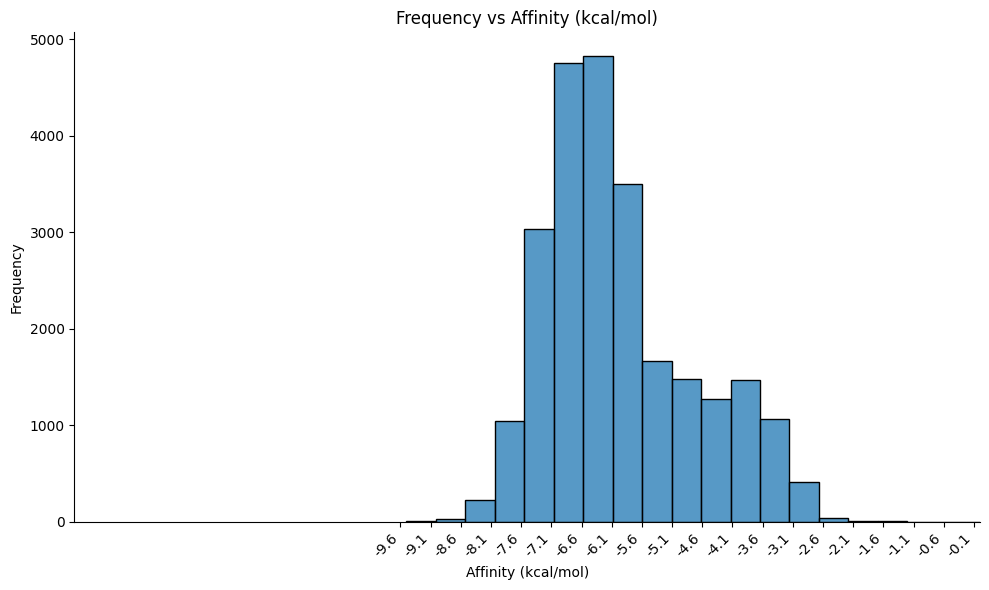

In [26]:
# @title Bar plot showing distribution of affinity (kcal/mol) vs frequnecy

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# Use the sorted dataframe which contains all affinities
# We can use more bins to make it look closer to a bar chart
plt.figure(figsize=(10, 6)) # Adjust figure size for better visibility
ax = sns.histplot(data=df_sorted, x='affinity (kcal/mol)', bins=50, kde=False) # Use histplot for better control and appearance

plt.xlabel('Affinity (kcal/mol)')
plt.ylabel('Frequency')
plt.title('Frequency vs Affinity (kcal/mol)')
sns.despine() # Remove spines for a cleaner look

# Set x-axis ticks to have intervals of 0.1
# Determine the range of affinities
min_affinity = df_sorted['affinity (kcal/mol)'].min()
max_affinity = df_sorted['affinity (kcal/mol)'].max()

# Create ticks at 0.1 intervals
# Adjust the range to cover slightly more than the data range for cleaner ticks
ticks = np.arange(np.floor(min_affinity*10)/10 - 0.1, np.ceil(max_affinity*10)/10 + 0.2, 0.5)
ax.set_xticks(ticks)
ax.set_xticklabels([f'{tick:.1f}' for tick in ticks], rotation=45, ha='right')

# Set the x-axis limits
ax.set_xlim([-15, 0])


plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

In [ ]:
# @title pocket rank vs mean binfing affinity (kcal/mol)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average affinity for each pocket rank
average_affinity_by_pocket = df_sorted.groupby('pocket rank')['affinity (kcal/mol)'].mean().reset_index()

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='pocket rank', y='affinity (kcal/mol)', data=average_affinity_by_pocket, ax=ax, palette='viridis')

# Ensure x-axis ticks are integers and centered
ax.set_xticks(average_affinity_by_pocket['pocket rank'])
ax.set_xticklabels(average_affinity_by_pocket['pocket rank'])

# Flip the y-axis
ax.set_ylim(ax.get_ylim()[::-1])

ax.set_xlabel('Pocket Rank')
ax.set_ylabel('Average Affinity (kcal/mol)')
ax.set_title('Average Affinity per Pocket Rank')
sns.despine(fig=fig, ax=ax)

plt.show()

ValueError: invalid literal for int() with base 10: '5RMM_pocket_restrained-pocket1'

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__del__'
Traceback (most recent call last):
  File "_zmq.py", line 160, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 


Error in callback <function _draw_all_if_interactive at 0x796d3fea25c0> (for post_execute):


KeyboardInterrupt: 